In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import unicodedata
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder

In [89]:
#Read and cleanup
df = pd.read_csv('data/movie_new.tsv', delimiter='\t', encoding='ISO-8859-1')

# indexes = df[ df['genre'] == 'News'].index
# df.drop(indexes, inplace=True)
# indexes = df[ df['genre'] == 'Game-Show'].index
# df.drop(indexes, inplace=True)
# indexes = df[ df['genre'] == 'Reality-TV'].index
# df.drop(indexes, inplace=True)
# indexes = df[ df['genre'] == 'Talk-Show'].index
# df.drop(indexes, inplace=True)
# indexes = df[ df['genre'] == 'Short'].index
# df.drop(indexes, inplace=True)
# indexes = df[ df['genre'] == 'Biography'].index
# df.drop(indexes, inplace=True)
# indexes = df[ df['genre'] == 'Film-Noir'].index
# df.drop(indexes, inplace=True)
#df.drop_duplicates(subset='movie', inplace=True)


In [105]:
df['genre'] = df['genre'].str.split(',') 
df.head()

,movie,genre,genres
0,Miss Jerry,[Romance],[Romance]
1,Soldiers of the Cross,"[Biography, Drama]","[Biography, Drama]"
2,The Story of the Kelly Gang,"[Biography, Crime, Drama]","[Biography, Crime, Drama]"
3,Robbery Under Arms,[Drama],[Drama]
4,Hamlet,[Drama],[Drama]


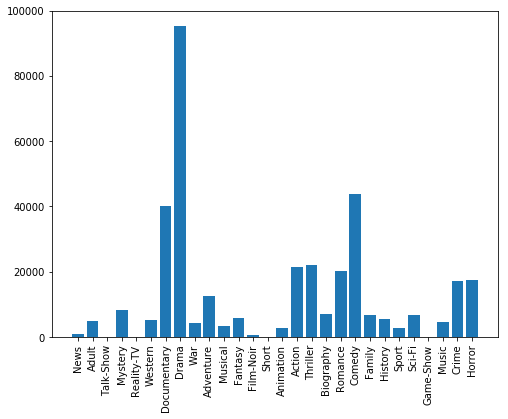

In [100]:
#Majority of movies are comedy, documentary or drama apparently.

fig = plt.figure(figsize=(8,6))
genreC = {}
for genres in df.genres:
    for genre in genres:
        try:
            genreC[genre] = genreC[genre] + 1
        except KeyError:
            genreC[genre] = 0
plt.bar(genreC.keys(), genreC.values())
plt.xticks(rotation=90)
plt.show()

In [101]:
from sklearn.svm import LinearSVC
from sklearn_porter import Porter

tfidf = TfidfVectorizer(lowercase = True, sublinear_tf=True, norm='l2', ngram_range=(1, 2), strip_accents='unicode')
features = tfidf.fit_transform(df.movie)
x_train, x_val, y_train, y_val, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.30, random_state=5000)
#unweighted:
svc = LinearSVC()
labels = df.genre_id
svc.fit(x_train, y_train)
print("unweighted:")
print(svc.score(x_val, y_val))

#weighted:
svc_w = LinearSVC(class_weight='balanced')
print("weighted")
svc_w.fit(x_train, y_train)
print(svc_w.score(x_val, y_val))

AttributeError: 'DataFrame' object has no attribute 'genre_id'

In [53]:
from sklearn.externals import joblib
joblib.dump(svc_w, 'model.pkl')

['model.pkl']

In [12]:
def getsvcprediction(model, title):
    return {title : id_to_category[model.predict(tfidf.transform([title]))[0]]}

In [13]:
#print(x_train)
print(getsvcprediction(svc, "Crocodile Dundee"))
print(getsvcprediction(svc, "Bee Movie"))
print(getsvcprediction(svc, "Toy Story"))
print(getsvcprediction(svc, "Zombies Return"))
print(getsvcprediction(svc, "Blade Runner"))
print(getsvcprediction(svc, "The Tower"))
print(getsvcprediction(svc, "Berlins Brewery"))
print(getsvcprediction(svc, "Bubble Kid"))
print(getsvcprediction(svc, "Overlord"))

print()
print(getsvcprediction(svc_w, "Crocodile Dundee"))
print(getsvcprediction(svc_w, "Bee Movie"))
print(getsvcprediction(svc_w, "Toy Story"))
print(getsvcprediction(svc_w, "Zombies Return"))
print(getsvcprediction(svc_w, "Blade Runner"))
print(getsvcprediction(svc_w, "The Tower"))
print(getsvcprediction(svc_w, "Berlins Brewery"))
print(getsvcprediction(svc_w, "Bubble Kid"))
print(getsvcprediction(svc_w, "Overlord"))


{'Crocodile Dundee': 'Comedy'}
{'Bee Movie': 'Adventure'}
{'Toy Story': 'Family'}
{'Zombies Return': 'Horror'}
{'Blade Runner': 'Sci-Fi'}
{'The Tower': 'Drama'}
{'Berlins Brewery': 'Music'}
{'Bubble Kid': 'Animation'}
{'Overlord': 'Drama'}

{'Crocodile Dundee': 'Comedy'}
{'Bee Movie': 'Adventure'}
{'Toy Story': 'Family'}
{'Zombies Return': 'Horror'}
{'Blade Runner': 'Sci-Fi'}
{'The Tower': 'Sci-Fi'}
{'Berlins Brewery': 'Music'}
{'Bubble Kid': 'Animation'}
{'Overlord': 'Drama'}


In [135]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit(df.genre)
labels = mlb.classes_

filter_length = 300
max_words = 8000
maxlen = 2000

num_classes = len(np.unique(df.genre))
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(df.movie)

def get_features(text_series):
    sequences = tokenizer.texts_to_sequences(text_series)
    return pad_sequences(sequences, maxlen=maxlen)

def prediction_to_label(prediction):
    tag_prob = [(labels[i], prob) for i, prob in enumerate(prediction.tolist())]
    return dict(sorted(tag_prob, key=lambda kv: kv[1], reverse=True))
    
def baseline():
    model = Sequential()
    model.add(Dense(28, input_dim=maxlen, activation='relu'))
    model.add(Dense(28, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy'])
    return model

def classify_movies_conv1d():
    # create model
    model = Sequential()
    model.add(Embedding(max_words, 28, input_length=maxlen))
    model.add(Dropout(0.1))
    model.add(Conv1D(filter_length, 3, padding='valid', activation='relu', strides=1))
    model.add(GlobalMaxPool1D())
    model.add(Dense(28))
    model.add(Activation('sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy'])
    return model

def classify_movies_maxpool():
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
    model.add(layers.GlobalMaxPool1D())
    model.add(layers.Dense(28, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model;

In [128]:
from sklearn.model_selection import train_test_split

x = get_features(df.movie)
y = mlb.transform(df.genre)
print(x.shape)
print(y.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=9000)

(221981, 2000)
(221981, 28)


In [142]:
countGenres = 0
for genres in df.genre:
    countGenres = countGenres + len(genres)

class_weight = {}
for index, label in enumerate(labels):
    class_weight[index] = count/genreC[label]
    print(label + " " + str(count/genreC[label]))


Action 83.71320456866933
Adult 369.4702868852459
Adventure 144.68103033220993
Animation 638.4614022662889
Biography 254.44750211685013
Comedy 41.03263466921554
Crime 105.45180722891567
Documentary 44.87232771708021
Drama 18.946995092527402
Family 263.2907418224299
Fantasy 304.51190677250463
Film-Noir 2583.1160458452723
Game-Show 450753.75
History 320.2513321492007
Horror 102.88245363766049
Music 388.4133993968117
Musical 518.1077586206897
Mystery 217.65028971511347
News 1823.0687563195147
Reality-TV 18587.78350515464
Romance 89.73795540513638
Sci-Fi 266.7181952662722
Short 200335.0
Sport 647.1697774587221
Talk-Show 64393.392857142855
Thriller 81.1437893789379
War 421.26518691588785
Western 352.77147329289767


In [145]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D

callbacks = [
    #ReduceLROnPlateau(),
    #EarlyStopping(patience=4),
    ModelCheckpoint(filepath='model-baseline-w-n.h5', save_best_only=True)
]

model = baseline()

import tensorflow as tf

history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=callbacks)

# cnn_model_uw = keras.models.load_model('model-conv1d_weighted.h5')
# metrics = cnn_model.evaluate(x_test, y_test)
# print("{}: {}".format(model.metrics_names[0], metrics[0]))
# print("{}: {}".format(model.metrics_names[1], metrics[1]))

# callbacks = [
#     ReduceLROnPlateau(),
#     EarlyStopping(patience=6),
#     ModelCheckpoint(filepath='model-conv1d_unweighted.h5', save_best_only=True)
# ]

# model = classify_movies_conv1d()
# history = model.fit(x_train, y_train,
#                     epochs=30,
#                     batch_size=32,
#                     validation_split=0.1,
#                     callbacks=callbacks)

# cnn_model_uw = keras.models.load_model('model-conv1d_unweighted.h5')
# metrics = cnn_model.evaluate(x_test, y_test)
# print("{}: {}".format(model.metrics_names[0], metrics[0]))
# print("{}: {}".format(model.metrics_names[1], metrics[1]))

Train on 159825 samples, validate on 17759 samples
Epoch 1/20
159825/159825 [==============================] - 41s 257us/step - loss: 0.2450 - categorical_accuracy: 0.2648 - val_loss: 0.1826 - val_categorical_accuracy: 0.2787
Epoch 2/20
159825/159825 [==============================] - 39s 246us/step - loss: 0.1777 - categorical_accuracy: 0.2852 - val_loss: 0.1779 - val_categorical_accuracy: 0.2774
Epoch 3/20
131840/159825 [=======================>......] - ETA: 6s - loss: 0.1753 - categorical_accuracy: 0.2849

KeyboardInterrupt: 

In [149]:
baseline_model = keras.models.load_model('model-baseline-w.h5')
f = get_features(["Toy Story"])
p1 = prediction_to_label(baseline_model.predict(f)[0])
df_t = pd.DataFrame()
df_t['label'] = p1.keys()
df_t['p'] = p1.values()
df_t.sort_values(by='p', ascending=False)[:20]

,label,p
7,Drama,0.427577
19,Comedy,0.196515
6,Documentary,0.187975
15,Action,0.098150
17,Thriller,0.096538
18,Romance,0.092897
26,Crime,0.080218
27,Horror,0.076642
9,Adventure,0.059707
3,Mystery,0.038345
